In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import surveyPRD

API path =  /home/ben/miniconda3/envs/pyPRD-dev/lib/python3.9/site-packages/resipy-3.3.3-py3.9.egg/resipy
ResIPy version =  3.3.3
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [83]:
df = surveyPRD.load_scale_data()
df.head()
df.datetime.dtype

dtype('<M8[ns]')

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'weight (kg)'), Text(0.5, 1.0, 'Raw data')]

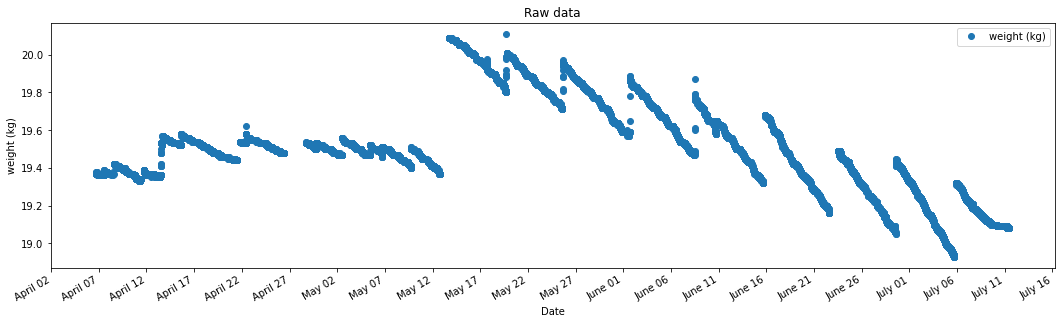

In [5]:
fig, ax = plt.subplots(figsize=(18, 5))

df.plot('datetime', 'weight (kg)', style='o', ax=ax)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
#ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))


# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="weight (kg)",
       title="Raw data")



In [85]:
df['cumweight'] = df['weight (kg)'].cumsum()
#data_scale['rolling'] = data_scale['weight (kg)'].rolling(20).sum()
df['rolling'] = df['weight (kg)'].rolling(12).mean()

df['rolling_std'] = df['weight (kg)'].rolling(12).std()
df['diff'] = df['rolling'].diff()

diurn=[]
for d in df['datetime']:
    #print(d)
    #print(int(d.strftime('%H')))
    if int(d.strftime('%H'))>=7 and int(d.strftime('%H'))<=19:
        diurn.append(True)
    else:
        diurn.append(False)

df['diurn'] = diurn  
df['diff']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1618    0.0
1619    0.0
1620    0.0
1621    0.0
1622    0.0
Name: diff, Length: 26065, dtype: float64

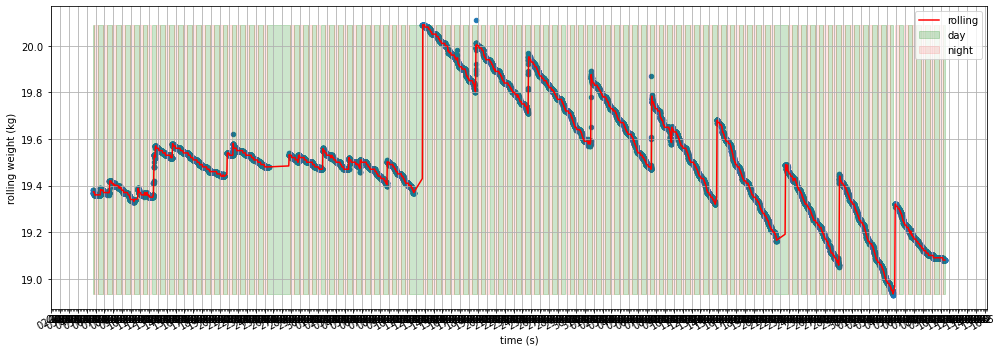

In [96]:
fig, ax = plt.subplots(figsize=(14, 5))

df.plot.scatter(x='datetime',y='weight (kg)', ax=ax)
df.plot(x='datetime',y='rolling', ax=ax, color='r')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

plt.gcf().autofmt_xdate()
ax.fill_between(df['datetime'], df['rolling'].min(), df['rolling'].max(), where=df['diurn']==True,
                color='green', alpha=0.2, label='day')
ax.fill_between(df['datetime'], df['rolling'].min(), df['rolling'].max(), where=df['diurn']==False,
                color='red', alpha=0.1, label='night')
plt.xlabel('time (s)')
plt.ylabel('rolling weight (kg)')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()
fig.savefig('../figures/allScaleData.png', 
            dpi=450,
            transparent=False)


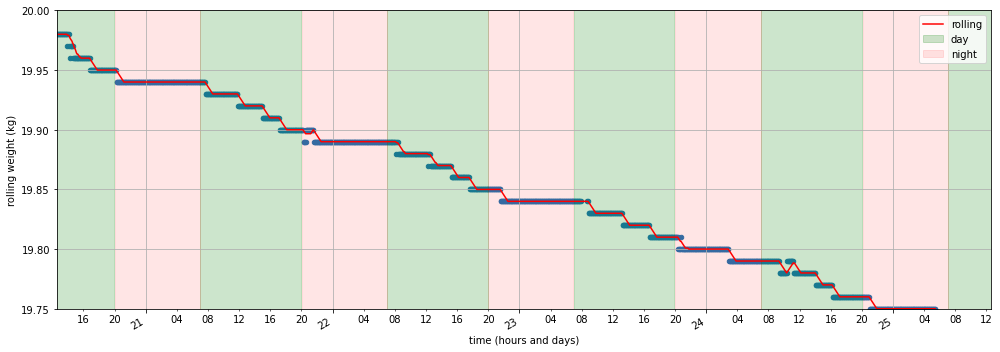

In [95]:
fig, ax = plt.subplots(figsize=(14, 5))

df.plot.scatter(x='datetime',y='weight (kg)', ax=ax)
df.plot(x='datetime',y='rolling', ax=ax, color='r')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

plt.gcf().autofmt_xdate()
ax.fill_between(df['datetime'], df['rolling'].min(), df['rolling'].max(), where=df['diurn']==True,
                color='green', alpha=0.2, label='day')
ax.fill_between(df['datetime'], df['rolling'].min(), df['rolling'].max(), where=df['diurn']==False,
                color='red', alpha=0.1, label='night')


date0 = '2022-05-20 12:36:00'
date1 =  '2022-05-25 12:36:00'

#print(df['datetime']==date0)
#date0 = pd.to_datetime('2022-05-20 12:36:00')
#date1 =  pd.to_datetime('2022-05-25 12:36:00')

#date0 = date0.astype('<M8[ns]')
ax.set_xlim([date0,date1])
ax.set_ylim([19.75,20])

#miny = df[df['datetime'].isin([date0,date1])]
#maxy = df[df['datetime'].isin([date0,date1])]

#ax.set_ylim([miny,maxy])

plt.xlabel('time (hours and days)')
plt.ylabel('rolling weight (kg)')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()
fig.savefig('../figures/1weekdata.png', 
            dpi=450,
            transparent=False)

In [51]:
# delete all positive variations
# cumsum during diurn/night

df['weight_diff']= df['weight (kg)'].diff()
df['weight_diff']

df_pos_diff = df[df['weight_diff'] >=0]
#df_pos_diff = df[df['weight_diff'] >0]

len(df)-len(df_pos_diff)


621

In [52]:
df_pos_diff
df_pos_diff.isna().sum()
#df_pos_diff.dropna(inplace=True)

date            0
time            0
sec             0
weight (kg)     0
abs_date        0
datetime        0
weight_diff     0
cumweight       0
rolling        10
rolling_std    10
diff           10
diurn           0
dtype: int64

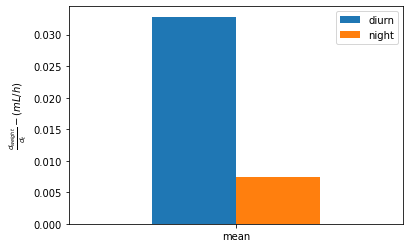

In [53]:
mean_diurn= df_pos_diff[df_pos_diff.loc[:,'diurn']==True]['weight_diff'].mean()
mean_day= df_pos_diff[df_pos_diff.loc[:,'diurn']==False]['weight_diff'].mean()

index = ['mean']
df = pd.DataFrame({'diurn': mean_diurn*5*1e3/60,
                   'night': mean_day*5*1e3/60}, index=index)
#ax = df.plot.bar(rot=0,ylabel=mean ')
ax = df.plot.bar(rot=0,ylabel=r'$\frac{d_{weight}}{d_{t}} - (mL/h)$')
plt.savefig('../figures/diurn_night_diff.png', dpi=400)

In [55]:
rhizo_surface_m2 = 0.03*0.5

#df['ET_sec'] = (df_pos_diff['weight_diff']*5*1e3/60)*rhizo_surface_m2
#data_scale['ET_h'] =  (weight_lost/round(delta.total_seconds()/60))*rhizo_surface_m2
